# Hypothesis : People on average lose money selling Options when IV is very high or very low.

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from pandas.tseries.offsets import BDay
import requests

Getting India VIX data from investing.com

In [204]:
url = 'https://in.investing.com/indices/india-vix-historical-data?end_date=1615119918&st_date=-1133069400'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

dfs = pd.read_html(r.text)
indiaVIX = dfs[1]

In [205]:
indiaVIX['Date'] = pd.to_datetime(indiaVIX['Date'])
indiaVIX = indiaVIX[['Date','Price']]
indiaVIX = indiaVIX.iloc[::-1]

Reading NIFTY data from CSV

In [206]:
NIFTY = pd.read_csv('NIFTY.csv')
NIFTY['Date'] = pd.to_datetime(NIFTY['Date'])
NIFTY = NIFTY[['Date','Adj Close']]
NIFTY['Adj Close'] = NIFTY['Adj Close'].fillna((NIFTY['Adj Close'].shift(-1) + NIFTY['Adj Close'].shift(-1))/2)
NIFTY['Adj Close'] = NIFTY['Adj Close'].fillna((NIFTY['Adj Close'].shift(-1)))
NIFTY['Adj Close'] = NIFTY['Adj Close'].fillna((NIFTY['Adj Close'].shift(1)))
NIFTY['Adj Close'] = NIFTY['Adj Close'].fillna((NIFTY['Adj Close'].shift(-1)))
NIFTY['Adj Close'] = NIFTY['Adj Close'].fillna((NIFTY['Adj Close'].shift(1)))
NIFTY['returns'] = (np.log(NIFTY['Adj Close'] /
    NIFTY['Adj Close'].shift(1)))
NIFTY['nifty20DayStd'] = ((NIFTY['returns'].rolling(20).std())*(np.sqrt(252)))*100
NIFTY = NIFTY.dropna()
NIFTY = NIFTY[['Date', 'nifty20DayStd']]
NIFTY = NIFTY[NIFTY['Date'] > '2008-03-03']

In [208]:
indiaVIX.tail()

,Date,Price
4,2021-03-01,25.625
3,2021-03-02,23.605
2,2021-03-03,22.090
1,2021-03-04,24.150
0,2021-03-05,25.560


Combining India VIX and NIFTY

In [209]:
resultDF = pd.merge(indiaVIX, NIFTY, on="Date")

In [210]:
resultDF

,Date,Price,nifty20DayStd
0,2008-03-04,38.080,40.880428
1,2008-03-05,35.510,40.319209
2,2008-03-07,35.200,39.796460
3,2008-03-10,32.580,39.943800
4,2008-03-11,32.690,35.744550
...,...,...,...
3196,2021-03-01,25.625,22.261433
3197,2021-03-02,23.605,20.744062
3198,2021-03-03,22.090,21.822940
3199,2021-03-04,24.150,22.142387


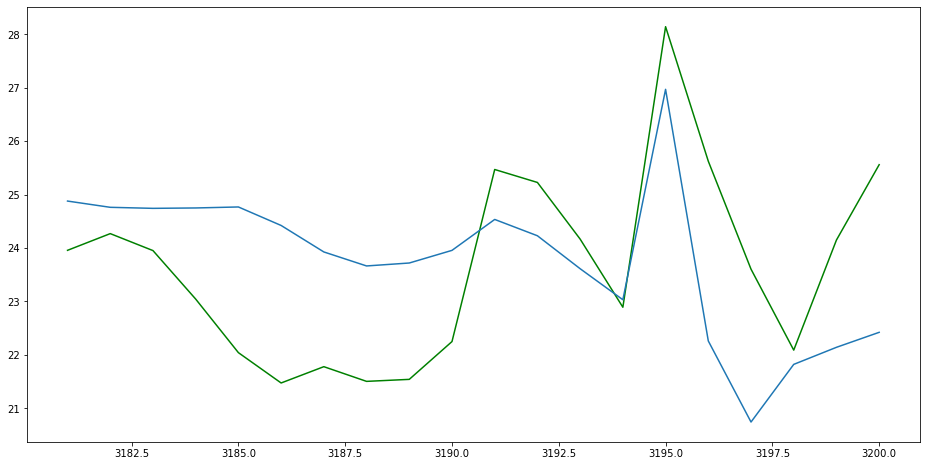

In [212]:
plt.figure(figsize=(16,8))
plt.plot(resultDF['Price'][-20:], color='green')
plt.plot(resultDF['nifty20DayStd'][-20:])
plt.show()

Creating a Dataframe where we can compare 1st December VIX with 20th December rolling 20 day stdev

In [214]:
finalDF = pd.DataFrame()
finalDF['IVdate'] = resultDF['Date']
finalDF['realVolDate'] = finalDF['IVdate'] + BDay(20)

In [215]:
finalDF = finalDF.merge(resultDF[['Price', 'Date']], left_on = 'IVdate', right_on = 'Date', how = 'left')

In [216]:
finalDF = finalDF[['IVdate', 'Price', 'realVolDate']]

In [217]:
finalDF = finalDF.merge(resultDF[['nifty20DayStd', 'Date']], left_on = 'realVolDate', right_on = 'Date', how = 'left')

In [218]:
finalDF = finalDF[['IVdate', 'Price', 'realVolDate', 'nifty20DayStd']]

In [219]:
finalDF['IV'] = finalDF['Price']
finalDF = finalDF[['IVdate', 'IV', 'realVolDate', 'nifty20DayStd']]
finalDF = finalDF.dropna()

Realised Vol on average is lower than IV as expected

In [223]:
print(finalDF['IV'].mean())
print(finalDF['nifty20DayStd'].mean())

21.56634288570481
18.229763126805583


VIX and Realized Vol for 2020

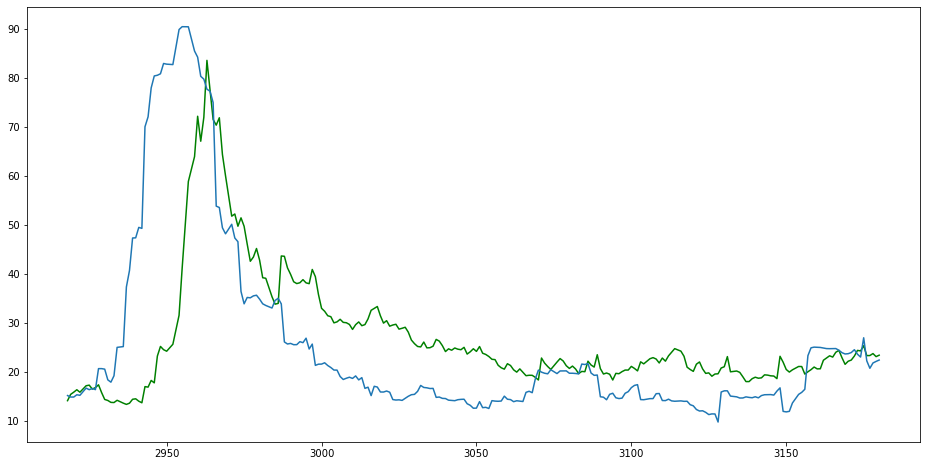

In [236]:
plt.figure(figsize=(16,8))
plt.plot(finalDF['IV'][-250:], color='green')
plt.plot(finalDF['nifty20DayStd'][-250:])
plt.show()

Difference between IV and real Vol

In [ ]:
finalDF['IVminusRealVol'] = finalDF['IV'] - finalDF['nifty20DayStd']

In [235]:
finalDF.tail()

,IVdate,IV,realVolDate,nifty20DayStd,IVminusRealVol
3176,2021-02-01,23.3225,2021-03-01,22.261433,1.061067
3177,2021-02-02,23.3450,2021-03-02,20.744062,2.600938
3178,2021-02-03,23.7450,2021-03-03,21.822940,1.922060
3179,2021-02-04,23.1225,2021-03-04,22.142387,0.980113
3180,2021-02-05,23.4150,2021-03-05,22.422833,0.992167


(array([ 39.,  77.,  97., 119., 169., 194., 187., 189., 199., 148., 130.,
        128., 114., 108., 100.,  69.,  60.,  60.,  59.,  66.,  50.,  57.,
         35.,  38.,  42.,  30.,  28.,  22.,  20.,  26.,  16.,  22.,  13.,
         25.,  14.,  19.,  14.,  14.,  12.,  10.,  15.,   9.,  10.,  10.,
         12.,   8.,  14.,   6.,   6.,   2.,   6.,   3.,   9.,   7.,   6.,
          4.,   2.,   3.,   4.,   4.,   2.,   1.,   3.,   3.,   1.,   1.,
          1.,   2.,   1.,   3.,   1.,   2.,   3.,   1.,   0.,   2.,   3.,
          2.,   0.,   1.,   2.,   1.,   3.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([10.4475  , 11.194325, 11.94115 , 12.687975, 13.4348  , 14.181625,
        14.92845 , 15.675275, 16.4221  , 17.168925, 17.91575 , 18.662575,
        19.4094  , 20.156225, 20.90305 , 21.649875, 22.3967  , 23.143525,
        23.89035 , 24.637175, 25.384   , 26.130825, 26.87765 , 27.624475,
        28.3713  , 29.

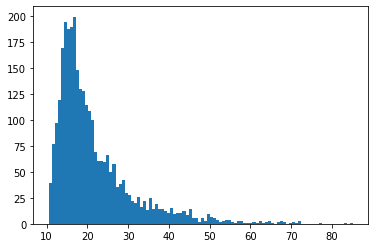

In [238]:
plt.hist(finalDF['IV'],bins = 100)

Dividing IV in 100 different percentiles

In [273]:
finalDF['percentile'] = pd.qcut(finalDF['IV'], 100, labels= range(0,100))

In [274]:
finalDF

,IVdate,IV,realVolDate,nifty20DayStd,IVminusRealVol,percentile
0,2008-03-04,38.0800,2008-04-01,46.098117,-8.018117,92
1,2008-03-05,35.5100,2008-04-02,46.130424,-10.620424,90
2,2008-03-07,35.2000,2008-04-04,43.002270,-7.802270,90
3,2008-03-10,32.5800,2008-04-07,43.770503,-11.190503,88
4,2008-03-11,32.6900,2008-04-08,42.555544,-9.865544,88
...,...,...,...,...,...,...
3176,2021-02-01,23.3225,2021-03-01,22.261433,1.061067,71
3177,2021-02-02,23.3450,2021-03-02,20.744062,2.600938,71
3178,2021-02-03,23.7450,2021-03-03,21.822940,1.922060,72
3179,2021-02-04,23.1225,2021-03-04,22.142387,0.980113,70


In [275]:
pltThis = finalDF.groupby('percentile').mean()

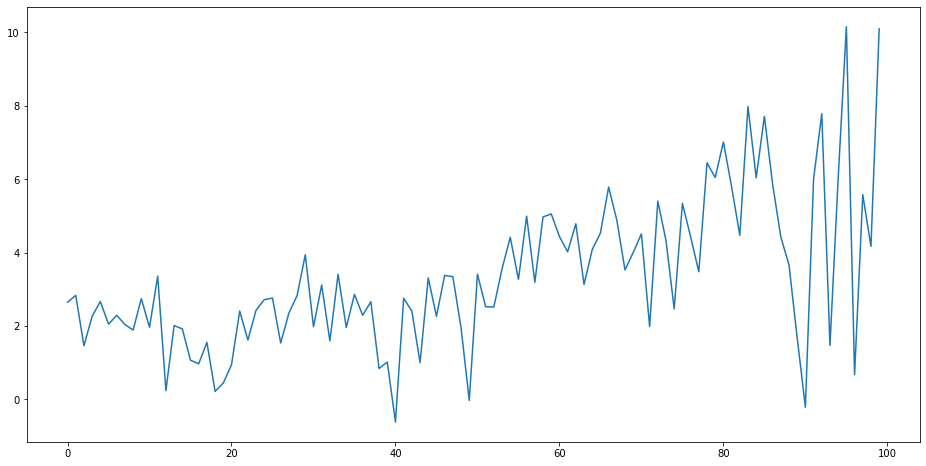

In [277]:
plt.figure(figsize=(16,8))
plt.plot(pltThis['IVminusRealVol'].values)
# plt.plot(pltThis['IV'].values)



Conclusion : Higher IV come with higher risk to reward and lower IV comes with lower risk to reward but on average both are profitable. So, our initial hypothesis is False. 